#### Helper Methods

In [3]:
#imports section
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt

In [4]:
# Global variables
log = True
component_path = "./sector_components/"
pricing_path = "./pricing/"
date_fmt = '%m-%d-%Y'

#variables for data download
frame = 20 #for limiting the range of optimizations, 1 year
hist_window = frame * 5 #for historical pricing
start_date = datetime.now() - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5

#variables for performance analysis
frequency = "W-THU"
lb, we = 20, 0.05 #ATTENTION this will drive the recomendations (re-run to check key vars)
g = 50
min_gross=0.7; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy_sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark_etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
# Mean variance optimization
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values    
def show_weights(weights, labels, ret, sigma):
    df = pd.DataFrame(weights, columns=labels)
    df['return'] = ret * 252
    df['sigma'] = sigma * np.sqrt(252)
    df['sharpe'] = df['return'] / df['sigma']
    return df
def get_weights(px, freq, lb, min_sum, max_sum, min_w, max_w):
    px = clean_nas(px)
    returns = px.sort_index().pct_change(); returns.iloc[0] = 0
    intervals = pd.to_datetime(date_intervals(returns, freq).index.tolist())
    valid_dates = [d for d in intervals if d in returns.index]    
    hist_alloc = pd.DataFrame(np.zeros((returns.shape)), index=returns.index, columns=returns.columns)
    for i in valid_dates:
        lb_returns = returns.loc[:i.date()].tail(lb).dropna()
        weights = np.array([0 for _ in range(len(returns.columns))])
        if (len(lb_returns) > 2):
            n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_returns)
            weights = get_mvo_allocations(
                n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w)
        hist_alloc.loc[i.date()] = weights
    hist_alloc = hist_alloc.loc[returns.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.replace(np.nan, 0, inplace=True)
    return returns, hist_alloc
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w):
    mu = mu_ret.T
    Sigma = cov_mtrx
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    # ATTENTION: Optimizaton constraints
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, 
         w > min_w, w < max_w])
    gamma.value = g; prob.solve()
    if prob.status == 'optimal': 
        return [i[0] for i in w.value.tolist()]
def recommend_allocs(px, frame, lb, freq, min_sum, max_sum, min_w, max_w):
    px = clean_nas(px)
    px_portion = px[-abs(frame):].copy() 
    returns, alloc = get_weights(
        px_portion, freq, lb, min_sum, max_sum, min_w, max_w)
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["M2-cvxopt"])
    return px_portion, returns, alloc, pdf
def period_allocs(w, irange):
    w = (recomend_allocs(w, irange) / max_w).astype(np.int)
    return w
# show top holdings and last recomended holding set
def selected_allocs(alloc, frame, freq, periods=99):
    w = alloc[-frame:].astype(np.float16)
    intervals = pd.to_datetime(date_intervals(w, freq).index.tolist())
    w = w.loc[intervals[-periods:]].sum(axis=0).sort_values(ascending=False)
    return w[w > 0]
def last_allocation(alloc, min_weight):
    last_alloc = alloc[-1:].T
    last_alloc.columns = ['Allocation']
    last_alloc = last_alloc[last_alloc[last_alloc.columns[0]] > min_weight]
    return last_alloc

In [6]:
# Portfolio utils
p_template = "{0} Return: {1:.2f}, StdDev: {2:.2f}, Sharpe: {3:.2f}"
def calc_port_performance(arr, weights):
    return np.cumprod(np.sum(arr * weights, axis=1) + 1)
def date_rules(date_range, tgt_date_str, freq):
    #return a list of dates
    tgt_dt = datetime.strptime(tgt_date_str, date_fmt)
    return date_range[:date_range.index(tgt_dt)+1][::-freq]
def date_intervals(df, freq):
    #using pandas
    return df.resample(freq, closed='left', label='left').mean()
# portfolio metrics: is this right? Need to be adjusted by len
# this is more a time series than a portfolio metric function 
# TODO: Need to create new function
# this calculates the variance of a time series, not a portfolio
def portfolio_metrics(name, pdf):
    timespan = len(pdf)
    ret = (pdf.pct_change().mean() * timespan).values[0]
    std = (pdf.pct_change().std() * sqrt(timespan)).values[0]
    if log: print(p_template.format(name, ret, std, ret / std))
    return ret, std, ret / std
def compute_metrics(px_hold, tickers, lb):
    sel_df = px_hold[tickers][-lb:].pct_change()[1:]
    sel_df_ret = sel_df.mean() * lb; sel_df_std = sel_df.std() * sqrt(lb)
    sel_df_sharpe = sel_df_ret / sel_df_std
    sel_df_spread = sel_df_ret - sel_df_std
    vals = np.array(
        [rec[rec.columns[0]].values, sel_df_ret.values, sel_df_std.values, 
         sel_df_sharpe.values, sel_df_spread,
         [dwld_key for i in range(len(tickers))]])
    sector_df = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
    return sector_df
def port_metrics(p, w, rec):
    # this is supposed to be the righ way to calculate the portfolio risk
    p.sort_index(inplace=True)
    returns = p[rec.index.tolist()].pct_change()
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    weights = np.asarray(rec.values)
    mult = len(mean_daily_returns)
    port_return = np.sum(mean_daily_returns.values * weights) * mult
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights))) * np.sqrt(mult)
    return port_return, port_risk[0][0]

In [7]:
# Sector analytics
def check_sector_vars(group, dwld_key, frame):
    lb_range = [i for i in range(5, 25, 10)]
    w_range = [i/100 for i in range(5, 20, 5)]
    for l in lb_range:
        for w in w_range:
            _, _, _, pdf, benchmark = run_sector_opt(group, dwld_key, frame, l, w)
            plt.plot(pdf, "-", alpha=0.5, label="lb:" + str(l) + "-w:" + str(w))
    plt.plot(benchmark, "g:", label=dwld_key)
    plt.legend(loc='best')
    plt.grid(axis='both', linestyle=':', linewidth=0.5)
    plt.title("M2 vs. " + dwld_key)
    plt.show()
def run_sector_opt(group, dwld_key, frame, lback, w):
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date') #this is inneficient, fix
    px_spy_etfs = load_pricing(group, 'Date') #this is inneficient, fix
    spyder_etf = px_spy_etfs[dwld_key].copy()
    # Run a sector specific optimization
    px_portion, returns, alloc, pdf = recommend_allocs(px, frame, lback, frequency, min_gross, max_gross, min_w, w)
    benchmark = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
    if log == True: 
        portfolio_metrics('M2', pdf);
        portfolio_metrics(dwld_key, pd.DataFrame(benchmark));
    return px_portion, returns, alloc, pdf, benchmark

In [8]:
# Plot utilities
# this method is not that useful, not thought out correctly
def plot_recomendations(picks, lb):
    # 1) get sectors 2) find stocks in sector pricing 3) merge all dfs into one 4) plot all as index
    sel_sectors = pd.unique(picks['Sector']) #1
    consol_px = pd.DataFrame([])
    idx_range = px_spy[-lb:].index
    for s in sel_sectors:
        s_px = load_pricing(s + '-hold-pricing.csv', 'Date').loc[idx_range].sort_index()
        s_px = clean_nas(s_px)
        s_tickers = picks[picks['Sector'] == s].index.tolist()
        s_df = s_px[s_tickers] #2
        consol_px = consol_px.merge(s_df, left_index=True, right_index=True, how='outer') #3
    compound(consol_px).plot() #4 plot compound
    print("From:", consol_px.index[0], "to: ", consol_px.index[-1])
    return consol_px
def plot_two_series(tsa, tsb, label1, label2, xlabel, ylabel, title):
    ax = tsa.plot(); tsb.plot(ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    ax.set_title(title)

In [9]:
# Download / load utility methods
#Downloads pricing on all components for each ETF
def get_pricing(fname, ticker_list, start_date):
    if log: print("Getting pricing for:", fname, start_date)
    px = web.DataReader(ticker_list,data_source='yahoo',start=start_date)['Adj Close']
    px.sort_index(ascending=True, inplace=True)
    px.to_csv(pricing_path + fname)
    return px
# Load pricing from hard drive
def load_pricing(f, idx_col):
    fname = pricing_path + f
    px = pd.read_csv(fname, index_col=idx_col, parse_dates=True)
    px.sort_index(ascending=True, inplace=True)
    if log: print("Loaded pricing for {}, with shape {}".format(f, px.shape))
    return px
# Load component from ETF holding CSVs
col_names = ['Symbol','Company', 'Weight']
def load_components(cos, pattern, cols, idxcol, sectors, srows=1):
    flist = os.listdir(component_path)
    files = [f for f in flist if f.startswith(pattern)]
    for s in sectors:
        fname = component_path + pattern + s.lower() + '.csv'
        df = pd.read_csv(fname, skiprows=srows, index_col=idxcol, usecols=cols)
        df.index.name = col_names[0]
        df.columns = col_names[1:]
        df = clean_idx(df, ' ')
        df['ETF'] = s
        sector_tickers_map[s] = df.index.tolist()
        cos = cos.append(df)
    return cos
# Exception safe downloader
def get_safe_pricing(fname, ticker_list, s_date):
    while True:
        try:
            get_pricing(fname, ticker_list, s_date); break
        except Exception as err:
            print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
            sleep(sleep_time)
#For each ETF downloads 
def refresh_components(etfs):
    while len(etfs) > 0: 
        val = etfs[-1]; 
        tickers = sector_tickers_map[val] # for individual components
        get_safe_pricing(val + '-hold-pricing.csv', tickers, start_date)
        etfs.pop()
def load_hold_and_benchmark(key):
    px_hold = load_pricing(key + '-hold-pricing.csv', 'Date')
    px_bench = px_spy_etfs[key].copy()
    return px_hold, px_bench
def load_spy_consol_px():
    consol_px = pd.DataFrame([])
    for dwld_key in ticker_map['spy_sectors']:
        px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')[frame:].copy()
        consol_px = consol_px.merge(px, left_index=True, right_index=True, how='outer')
    return consol_px

In [10]:
# Clean utilities
cleanmin = lambda x: max(float(x), 1)
short_float = lambda x: '%.3f' % x
def compound(df):
    pct = df.pct_change() + 1
    pct.iloc[0] = 1
    return pct.cumprod()
def clean_load(pattern, idxcol, cols, col_names, s, srows=0):
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=srows, index_col=idxcol, usecols=cols)
    df.index.name = col_names[0]
    df.columns = col_names[1:]
    return df
def clean_idx(df, s):
    dfidx = df.index.dropna()
    df = df.loc[dfidx].copy()
    rows = df[df.index.str.contains(s) == True]
    if len(rows) > 0:
        idx = df[df.index.str.contains(s) == True].index
        df = df.drop(idx, axis=0)
    return df
def clean_nas(df):
    cols = df.count().sort_values()[df.count().sort_values() < 1].index.tolist()
    df = df.drop(cols, axis=1)
    df.fillna(method='pad', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df = df.applymap(cleanmin)
    return df

#### Load sector components from hard-drive

In [11]:
sector_tickers_map = {}
companies = pd.DataFrame([])

# load spy sector components
companies = load_components(
    companies, r'holdings-spy-', ['Symbol','Company Name', 'Index Weight'], 
    'Symbol', ticker_map['spy_sectors'], srows=1)
print("Companies loaded:", companies.shape)

# load ark ETF components
"""
companies = load_components(
    companies, r'holdings-ark-', ['ticker','company', 'weight(%)'], 
    'ticker', ticker_map['ark_etfs'], srows=0)
print("Companies loaded:", companies.shape)
"""

px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
#px_ark_etfs = load_pricing('ark-etfs.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

# load ark etfs components

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (68, 10)
Loaded pricing for SPY.csv, with shape (68, 1)


#### Get Data from the Server

In [10]:
# PENDING logic for appending prices instead of download over and over again
dr = pd.date_range(end='2-1-18', periods=10)
np.random.seed(42)
series = np.random.random(50).reshape(10, 5)
dra, drb = dr[:7], dr[-7:]
sa, sb = series[:7], series[-7:]
cols = ['A', 'B', 'C', 'D', 'E']
dfa, dfb = pd.DataFrame(sa, index=dra, columns=cols), pd.DataFrame(sb, index=drb, columns=cols)
dfb.combine_first(dfa)
#dfa, dfb

A         B         C         D         E
2018-01-23  0.374540  0.950714  0.731994  0.598658  0.156019
2018-01-24  0.155995  0.058084  0.866176  0.601115  0.708073
2018-01-25  0.020584  0.969910  0.832443  0.212339  0.181825
2018-01-26  0.183405  0.304242  0.524756  0.431945  0.291229
2018-01-27  0.611853  0.139494  0.292145  0.366362  0.456070
2018-01-28  0.785176  0.199674  0.514234  0.592415  0.046450
2018-01-29  0.607545  0.170524  0.065052  0.948886  0.965632
2018-01-30  0.808397  0.304614  0.097672  0.684233  0.440152
2018-01-31  0.122038  0.495177  0.034389  0.909320  0.258780
2018-02-01  0.662522  0.311711  0.520068  0.546710  0.184854

In [11]:
spyder_etfs = [e for e in ticker_map['spy_sectors']]
ark_etfs = [e for e in ticker_map['ark_etfs']]
refresh_components(spyder_etfs)
#refresh_components(ark_etfs)

Getting pricing for: XLRE-hold-pricing.csv 11-14-2017
Getting pricing for: XLF-hold-pricing.csv 11-14-2017


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'BRK.b', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Getting pricing for: XLV-hold-pricing.csv 11-14-2017
Getting pricing for: XLI-hold-pricing.csv 11-14-2017
Getting pricing for: XLY-hold-pricing.csv 11-14-2017
Getting pricing for: XLP-hold-pricing.csv 11-14-2017


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'BF.b', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Getting pricing for: XLB-hold-pricing.csv 11-14-2017
Getting pricing for: XLK-hold-pricing.csv 11-14-2017
Getting pricing for: XLU-hold-pricing.csv 11-14-2017
Getting pricing for: XLE-hold-pricing.csv 11-14-2017


In [12]:
get_safe_pricing('spy-sectors.csv', ticker_map['spy_sectors'], start_date)
#get_safe_pricing('ark-etfs.csv', ticker_map['ark_etfs'], start_date)
get_safe_pricing('SPY.csv', ['SPY'], start_date)

px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
#px_ark_etfs = load_pricing('ark-etfs.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Getting pricing for: spy-sectors.csv 11-14-2017
Getting pricing for: SPY.csv 11-14-2017
Loaded pricing for spy-sectors.csv, with shape (68, 10)
Loaded pricing for SPY.csv, with shape (68, 1)


#### Generate Trading Recomendations

TODO List
1. Produce ETF level recomendation (sector weightings) DONE
2. Produce recomendations for each sector DONE
3. Calculate sharpe rankings for a given company list DONE
4. Show spread returns starting at different times for each sector
5. Create long / short optimizers
6. Test portofolio with both long and shorts

In [12]:
sum_cols = ["Allocation", "Return", "StdDev", "Sharpe", "Spread", "Sector"]
summary = pd.DataFrame([], columns=sum_cols)
sector_port = pd.DataFrame([], columns=sum_cols)
consol_px = load_spy_consol_px()
top = int(1/we);
log = False
#Produce best recomendations by sector
for dwld_key in ticker_map['spy_sectors']:
    if log: print("Running optimization for:", dwld_key)
    # Load pricing for ETF and all its components
    px_hold, spyder_etf = load_hold_and_benchmark(dwld_key)
    # Run optimization for ETF Components
    px_portion, returns, alloc, pdf = recommend_allocs(
        px_hold, frame, lb, frequency, min_gross, max_gross, min_w, we)
    rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
    px_a = consol_px[rec.index][-lb:]
    px_pct = px_a.pct_change()
    mu_a = np.dot(px_pct.mean().values, rec.values) * lb
    std_a = np.dot(px_pct.std().values, rec.values) * sqrt(lb)
    sr_a = mu_a / std_a
    print(dwld_key, "Ret:", short_float(mu_a), "StdDev:", short_float(std_a), "Sharpe:", short_float(sr_a))

    # List recomended positions per sector
    if len(tickers) > 0:
        sector_df = compute_metrics(px_hold, tickers, lb)
        summary = summary.append(sector_df)
summary = summary.astype({"Allocation": np.float, "Return": np.float, "StdDev": np.float, "Sharpe": np.float, "Spread": np.float})

Loaded pricing for XLE-hold-pricing.csv, with shape (68, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (68, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (68, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (68, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (68, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (68, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (68, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (68, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (68, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (68, 33)
XLE Ret: -0.062 StdDev: 0.064 Sharpe: -0.979
XLU Ret: -0.018 StdDev: 0.044 Sharpe: -0.406
XLK Ret: 0.039 StdDev: 0.069 Sharpe: 0.560
XLB Ret: -0.010 StdDev: 0.059 Sharpe: -0.174
XLP Ret: 0.001 StdDev: 0.061 Sharpe: 0.010
XLY Ret: 0.014 StdDev: 0.067 Sharpe: 0.213
XLI Ret: 0.013 StdDev: 0.054 Sharpe: 0.243
XLV Ret: -0.003 StdDev: 0.054 Sharpe: -0.060
XLF Ret: 0.020 StdDev: 0.057 Sharpe: 

Market wide approach

In [13]:
# Run optimization for all members of the SPY
# TODO: Show as a matrix not as a set of print statements
lbs = [x for x in range(5, 25, 5)]
ws = [y/100 for y in [x for x in range(5, 20, 5)]]

log = True
for l in lbs:
    for w in ws:
        px_portion, returns, alloc, pdf = recommend_allocs(
            consol_px, frame, l, frequency, min_gross, max_gross, min_w, w)
        rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
        print("M2", l, w, rec.count().values, "positions ", rec.sum().values, "long exp.")
        portfolio_metrics('M2', pdf)

M2 5 0.05 [22] positions  [ 1.] long exp.
M2 Return: 0.04, StdDev: 0.07, Sharpe: 0.60
M2 5 0.1 [12] positions  [ 1.] long exp.
M2 Return: 0.06, StdDev: 0.08, Sharpe: 0.73
M2 5 0.15 [9] positions  [ 0.99630842] long exp.
M2 Return: 0.08, StdDev: 0.09, Sharpe: 0.87
M2 10 0.05 [23] positions  [ 0.99297914] long exp.
M2 Return: 0.01, StdDev: 0.06, Sharpe: 0.21
M2 10 0.1 [14] positions  [ 1.] long exp.
M2 Return: 0.02, StdDev: 0.07, Sharpe: 0.38
M2 10 0.15 [12] positions  [ 1.] long exp.
M2 Return: 0.04, StdDev: 0.07, Sharpe: 0.53
M2 15 0.05 [17] positions  [ 0.69878705] long exp.
M2 Return: 0.01, StdDev: 0.06, Sharpe: 0.14
M2 15 0.1 [10] positions  [ 0.7] long exp.
M2 Return: 0.02, StdDev: 0.06, Sharpe: 0.32
M2 15 0.15 [7] positions  [ 0.69135707] long exp.
M2 Return: 0.03, StdDev: 0.07, Sharpe: 0.44
M2 20 0.05 [15] positions  [ 0.67405386] long exp.
M2 Return: 0.01, StdDev: 0.06, Sharpe: 0.14
M2 20 0.1 [9] positions  [ 0.69194379] long exp.
M2 Return: 0.02, StdDev: 0.06, Sharpe: 0.32
M2 2

In [ ]:
del opt_df
opt_cols = ["Return", "Risk", "Sharpe"]
opt_df = pd.DataFrame([], index=gamma_vals, columns=opt_cols)
for i in gamma_vals:
    ret, risk = i*10, i*20
    vals = [ret, risk, ret / risk]
    opt_df.loc[i][opt_cols] = vals
opt_df

In [237]:
# Fine-tunned parameters
# TODO: Add generic stats: As of Date, lookback, weights, etc to check things are running correctly
lb, max_w = 20, 0.05

# Compute trade-off curve.
SAMPLES = 100
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
opt_cols = ["Return", "Risk", "Sharpe"]
opt_df = pd.DataFrame([], index=gamma_vals, columns=opt_cols)
print("Frame: {}, Lookback: {}, MinGrossAlloc: {}, MaxGrossAlloc: {}, MinWeight: {}, MaxWeight: {}".format(frame, lb, min_gross, max_gross, min_w, max_w))
for i in gamma_vals:
    g = i
    px_portion, returns, alloc, pdf = recommend_allocs(
        consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w)
    rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
    #print("Nbr of Positions: {}, Total Exposure: {}".format(rec.count().values, rec.sum().values))
    #print("Portfolio Metrics")
    #portfolio_metrics('M2', pdf)
    ret, risk = port_metrics(px_portion, alloc, rec)
    opt_df.loc[i][opt_cols] = [ret, risk, ret / risk]
    #print("Gamma: {0:.2f}, Ret: {1:.2f}, PortRisk: {2:.2f}, Sharpe: {3:.2f}".format(g, ret, risk, ret / risk))
    #plot_two_series(pdf, compound(px_spy.loc[pdf.index]), 'M2', 'SPY', 'Days','Index Return', 'Excess Returns')
top = 10
best_gamma_ports = opt_df.sort_values(by='Sharpe', ascending=False).head(top)
portfolio_metrics('SPY', px_spy.loc[pdf.index]);
best_gamma_ports

Frame: 20, Lookback: 20, MinGrossAlloc: 0.7, MaxGrossAlloc: 1, MinWeight: 0, MaxWeight: 0.05
SPY Return: -0.04, StdDev: 0.08, Sharpe: -0.47


Return       Risk   Sharpe
9.545485   3.06158  0.0663615   46.135
8.497534   2.86438  0.0655831  43.6757
10.722672  2.67552  0.0619008  43.2228
7.564633   2.93689  0.0695973  42.1983
6.734151   2.96334  0.0705211  42.0206
5.994843   2.96334  0.0718073   41.268
17.073526  1.76148  0.0432291  40.7475
4.229243   3.00801  0.0745767  40.3344
3.764936   3.00801  0.0748133  40.2069
13.530478  2.05845  0.0512871  40.1358

In [243]:
top_gammas = best_gamma_ports.index.tolist()
ten_best = pd.DataFrame([], index=top_10_gammas, columns=[])
for i in top_gammas:
    g = i
    px_portion, returns, alloc, pdf = recommend_allocs(
        consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w)
    rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
    df = pd.DataFrame(rec.T.values, index=[g], columns=rec.index)
    ten_best = ten_best.combine_first(df)
ten_best = ten_best.applymap(short_float).loc[best_gamma_ports.index].astype(np.float)
ten_best

ABBV   ALK   AMZN  COTY   CSRA   DPS     EA   EBAY     EW     FE  \
9.545485     NaN  0.05  0.050  0.05  0.050  0.05  0.050  0.021  0.050  0.050   
8.497534     NaN  0.05  0.050  0.05  0.050  0.05  0.050  0.015  0.050  0.050   
10.722672    NaN  0.05  0.050  0.05  0.050  0.05  0.050  0.014  0.050  0.050   
7.564633   0.025   NaN  0.050  0.05  0.050  0.05  0.050    NaN  0.050  0.050   
6.734151   0.032   NaN  0.050  0.05  0.050  0.05  0.050    NaN  0.048  0.050   
5.994843   0.043   NaN  0.050  0.05  0.050  0.05  0.050    NaN  0.036  0.039   
17.073526    NaN  0.04  0.010  0.05  0.048  0.05  0.016    NaN  0.050  0.050   
4.229243   0.050   NaN  0.050  0.05  0.050  0.05  0.050  0.016  0.034    NaN   
3.764936   0.050   NaN  0.050  0.05  0.050  0.05  0.050  0.024  0.026    NaN   
13.530478    NaN  0.05  0.032  0.05  0.050  0.05  0.046    NaN  0.050  0.050   

           ...     MAT   MSI    NWL  QRVO   RHT  SWKS  TRIP     UA    UAA  \
9.545485   ...   0.010  0.05    NaN  0.05  0.05  0.05  0.05  0.018  0.050   
8.497534   ...     NaN  0.05    NaN  0.05  0.05  0.05  0.05  0.028  0.050   
10.722672  ...   0.011  0.05    NaN  0.05  0.05  0.05  0.05    NaN  0.050   
7.564633   ...     NaN  0.05  0.016  0.05  0.05  0.05  0.05  0.050  0.050   
6.734151   ...     NaN  0.05  0.020  0.05  0.05  0.05  0.05  0.050  0.050   
5.994843   ...     NaN  0.05  0.032  0.05  0.05  0.05  0.05  0.050  0.050   
17.073526  ...   0.012  0.05    NaN  0.05  0.05  0.05  0.05    NaN  0.018   
4.229243   ...     NaN  0.05  0.050  0.05  0.05  0.05  0.05  0.050  0.050   
3.764936   ...     NaN  0.05  0.050  0.05  0.05  0.05  0.05  0.050  0.050   
13.530478  ...     NaN  0.05    NaN  0.05  0.05  0.05  0.05    NaN  0.034   

             XL  
9.545485   0.05  
8.497534   0.05  
10.722672  0.05  
7.564633   0.05  
6.734151   0.05  
5.994843   0.05  
17.073526  0.05  
4.229243   0.05  
3.764936   0.05  
13.530478  0.05  

[10 rows x 24 columns]

In [245]:
# Average portfolio
avg_port = ten_best.sum().sort_values(ascending=False) / 10
(avg_port / avg_port.sum())

XL      0.052078
TRIP    0.052078
SWKS    0.052078
RHT     0.052078
QRVO    0.052078
COTY    0.052078
MSI     0.052078
IPG     0.052078
HRS     0.052078
DPS     0.052078
CSRA    0.051870
HCA     0.049578
EA      0.048120
UAA     0.047078
EW      0.046245
AMZN    0.046037
HII     0.042808
FE      0.040517
UA      0.030830
ALK     0.024997
ABBV    0.020831
NWL     0.017498
EBAY    0.009374
MAT     0.003437
dtype: float64

In [241]:
# A selected portfolio
sel = 0
ten_best.iloc[sel][(ten_best.iloc[sel] > 0).values]

ALK     0.050
AMZN    0.050
COTY    0.050
CSRA    0.050
DPS     0.050
EA      0.050
EBAY    0.021
EW      0.050
FE      0.050
HCA     0.050
HII     0.050
HRS     0.050
IPG     0.050
MAT     0.010
MSI     0.050
QRVO    0.050
RHT     0.050
SWKS    0.050
TRIP    0.050
UA      0.018
UAA     0.050
XL      0.050
Name: 9.54548456662, dtype: float64

In [19]:
# Stats for results of market wide optimization
mw_summary = compute_metrics(consol_px, tickers, lb)
mw_summary['Sector'] = companies.loc[tickers]['ETF']
mw_summary['Company'] = companies.loc[mw_summary.index][['Company']]
mw_summary = mw_summary.astype({"Allocation": np.float, "Return": np.float, "StdDev": np.float, "Sharpe": np.float, "Spread": np.float})
companies.loc[mw_summary.index][['Company', 'ETF']]

Company   ETF
BHGE          Baker Hughes, a GE company   XLE
CHK               Chesapeake Energy Corp   XLE
EQT                      EQT Corporation   XLE
NBL                     Noble Energy Inc   XLE
SCG                           SCANA Corp   XLU
AMAT               Applied Materials Inc   XLK
INTU                          Intuit Inc   XLK
RHT                          Red Hat Inc   XLK
CF                CF Industries Holdings   XLB
MOS                            Mosaic Co   XLB
CMG          Chipotle Mexican Grill Inc.   XLY
ALLE                        Allegion plc   XLI
HII   Huntington Ingalls Industries Inc.   XLI
PWR                  Quanta Services Inc   XLI
UTX             United Technologies Corp   XLI
ABBV                         AbbVie Inc.   XLV
ALGN                Align Technology Inc   XLV
ZTS                           Zoetis Inc   XLV
KIM                    Kimco Realty Corp  XLRE
SBAC             SBA Communications Corp  XLRE

In [22]:
recomend = mw_summary.loc[tickers].sort_values(by='Spread', ascending=False)
recomend['Allocation'] = rec.values
re_group = recomend.groupby(by='Sector')
print("Total % Allocation {0:.2f}".format(recomend.Allocation.sum()));
print(re_group.sum()['Allocation'])
print(re_group.mean())

Total % Allocation 1.00
Sector
XLB     0.100000
XLE     0.150000
XLI     0.323143
XLK     0.161270
XLRE    0.050000
XLV     0.150000
XLY     0.065586
Name: Allocation, dtype: float64
        Allocation    Return    StdDev    Sharpe    Spread
Sector                                                    
XLB       0.050000  0.089848  0.054840  1.647807  0.035008
XLE       0.050000  0.165184  0.165755  1.314558 -0.000572
XLI       0.046163  0.051060  0.039798  1.457285  0.011262
XLK       0.040318  0.050913  0.025951  1.998652  0.024961
XLRE      0.050000  0.044474  0.022175  2.005623  0.022299
XLV       0.050000  0.048956  0.025852  2.249080  0.023103
XLY       0.032793  0.091038  0.091084  1.126932 -0.000046


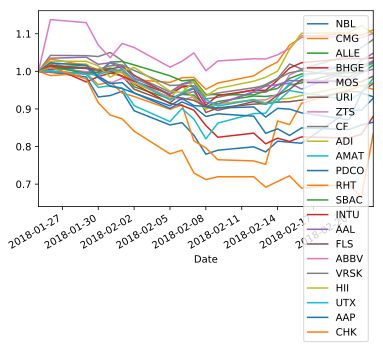

In [23]:
compound(consol_px[recomend.index][-frame:]).plot()

In [41]:
# Outputs for trade execution
px_a = consol_px[recomend.index][-lb:]
px_pct = px_a.pct_change()
mu_a = np.dot(px_pct.mean().values, rec.values) * lb
std_a = np.dot(px_pct.std().values, rec.values) * sqrt(lb)
sr_a = mu_a / std_a
print("Ann. Ret:", short_float(mu_a), "StdDev:", short_float(std_a), "Sharpe:", short_float(sr_a))

round_shares = lambda x: round(x, 0)
port_bal = 227000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px_a[-1:]
shares.apply(round_shares).T.sort_index()

# Create a DataFrame with tickers as index, columns: name, price, allocation, dollar value, shares to buy
# Show some basic metrics like date, total value invested, and sum total allocation

Ann. Ret: 0.073 StdDev: 0.059 Sharpe: 1.232


Date  2018-02-22
AAL        213.0
AAP        101.0
ABBV        95.0
ADI        127.0
ALLE       130.0
AMAT       200.0
BHGE       401.0
CF         261.0
CHK       3434.0
CMG         11.0
FLS        118.0
HII         43.0
INTU        65.0
MOS        406.0
NBL        376.0
PDCO       351.0
RHT         18.0
SBAC        66.0
URI         64.0
UTX         84.0
VRSK       112.0
ZTS        139.0

In [37]:
add_cols = ['Company', 'ETF']
companies.loc[shares.columns][add_cols].sort_index().T

AAL                     AAP         ABBV  \
Company  American Airlines Group Inc.  Advance Auto Parts Inc  AbbVie Inc.   
ETF                               XLI                     XLY          XLV   

                        ADI          ALLE                   AMAT  \
Company  Analog Devices Inc  Allegion plc  Applied Materials Inc   
ETF                     XLK           XLI                    XLK   

                               BHGE                      CF  \
Company  Baker Hughes, a GE company  CF Industries Holdings   
ETF                             XLE                     XLB   

                            CHK                          CMG     ...      \
Company  Chesapeake Energy Corp  Chipotle Mexican Grill Inc.     ...       
ETF                         XLE                          XLY     ...       

               INTU        MOS               NBL               PDCO  \
Company  Intuit Inc  Mosaic Co  Noble Energy Inc  Patterson Cos Inc   
ETF             XLK        XLB               XLE                XLV   

                 RHT                     SBAC                 URI  \
Company  Red Hat Inc  SBA Communications Corp  United Rentals Inc   
ETF              XLK                     XLRE                 XLI   

                              UTX                  VRSK         ZTS  
Company  United Technologies Corp  Verisk Analytics Inc  Zoetis Inc  
ETF                           XLI                   XLI         XLV  

[2 rows x 22 columns]

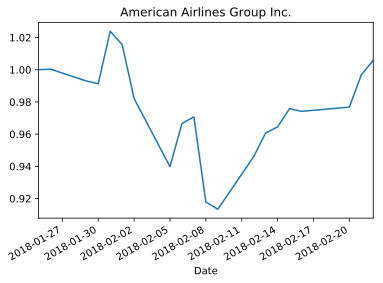

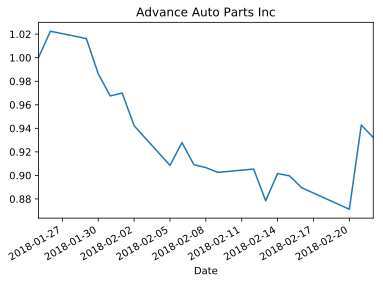

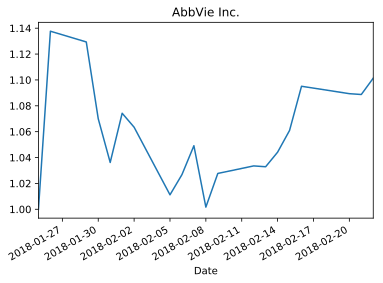

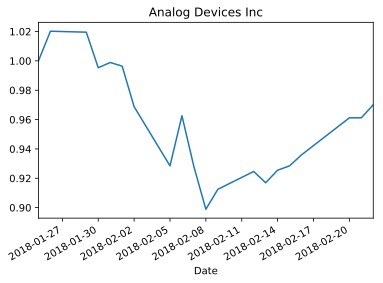

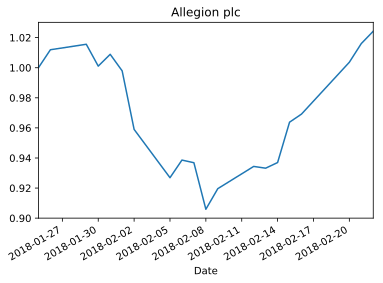

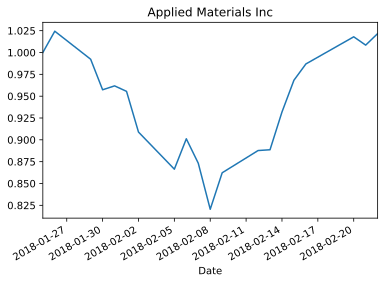

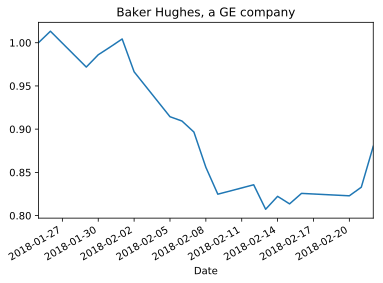

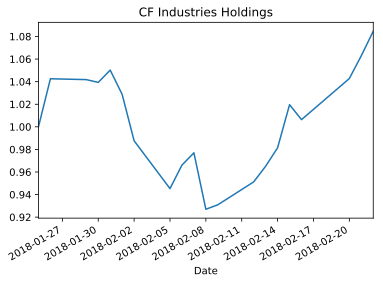

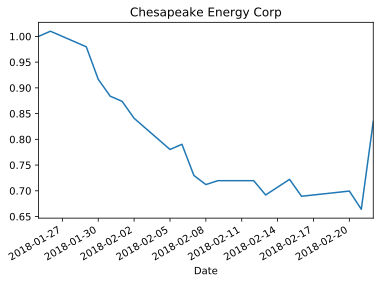

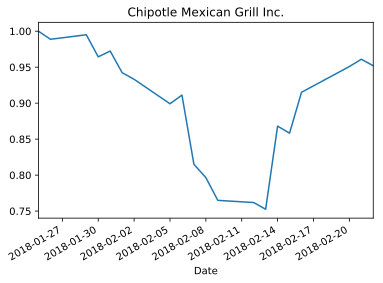

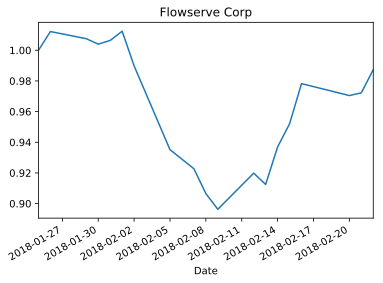

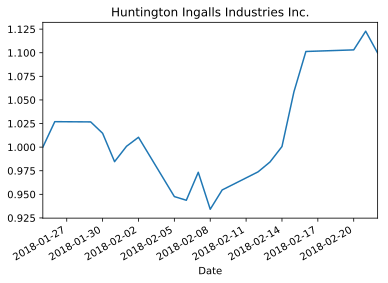

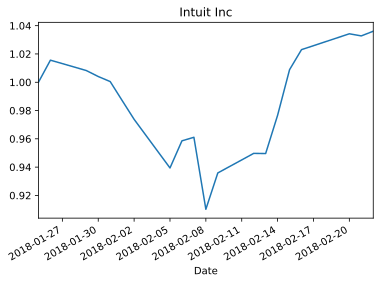

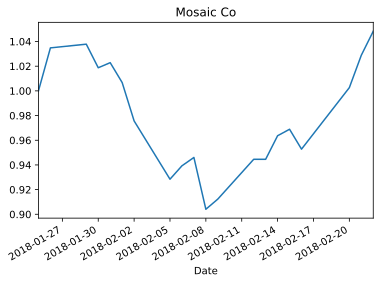

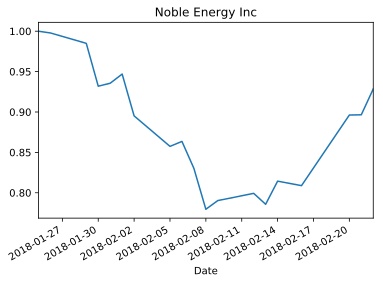

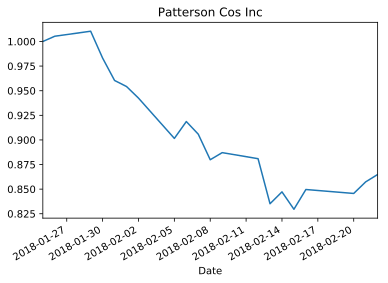

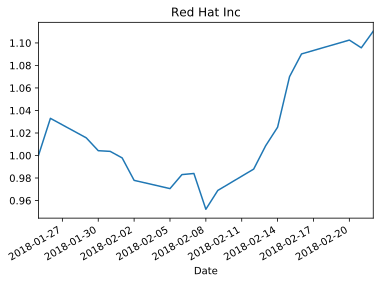

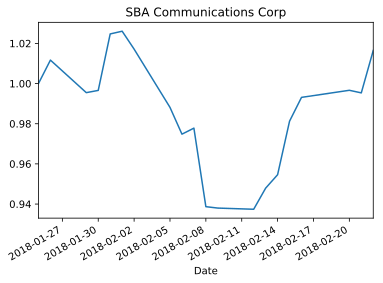

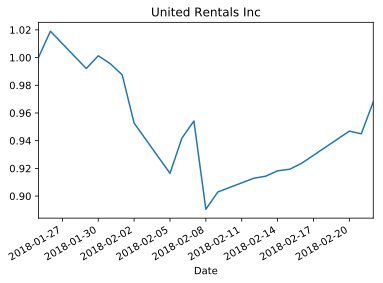

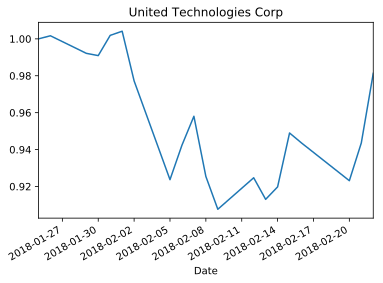

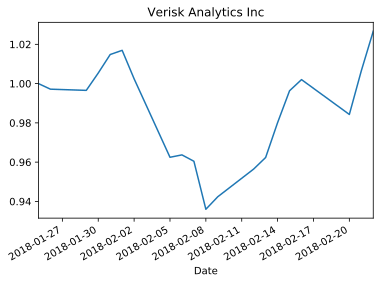

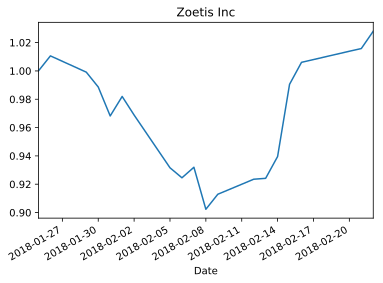

In [50]:
for t in recomend.sort_index().index:
    compound(consol_px[t][-frame:]).plot()
    plt.title(companies.loc[t]['Company'])
    plt.show()

#### Run Optimizations

M2 Return: 0.00, StdDev: 0.00, Sharpe: nan
SPY Return: 0.06, StdDev: 0.08, Sharpe: 0.72


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


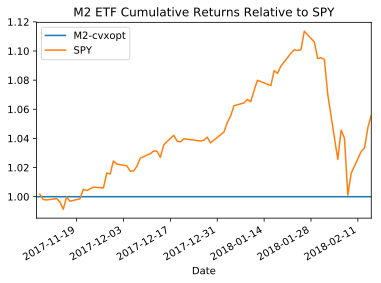

In [21]:
#Produce ETF level recomendation (sector weightings)
log = True
etfs_px_portion, etfs_ret, etfs_alloc, etfs_pdf = recommend_allocs(
    px_spy_etfs, hist_window, lb, frequency, min_gross, max_gross, min_w, we)
portfolio_metrics('M2', etfs_pdf)

s_spy = (px_spy[-len(etfs_px_portion):].pct_change() + 1).cumprod()
portfolio_metrics('SPY', s_spy)
# Plot optimization vs. benchmark
ax = etfs_pdf.plot(title="M2 ETF Cumulative Returns Relative to SPY");
s_spy.plot(ax=ax, legend='right');

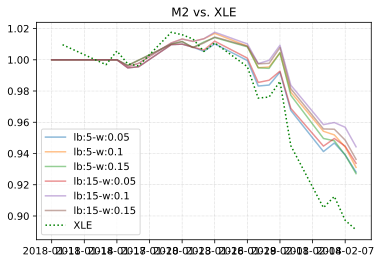

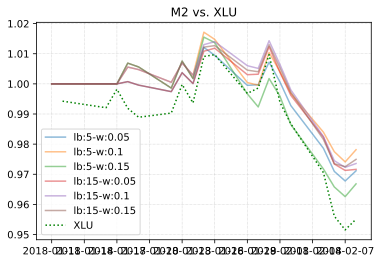

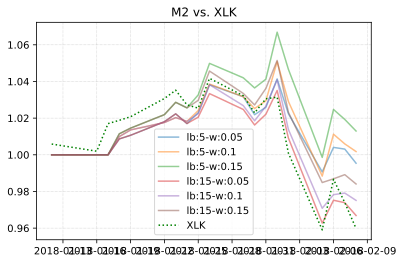

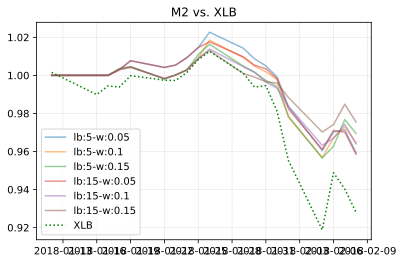

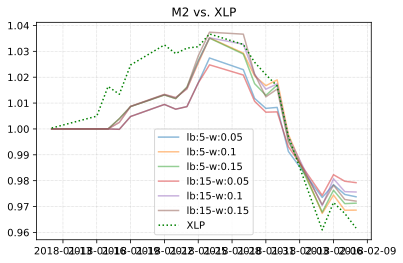

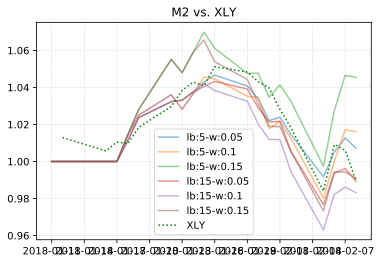

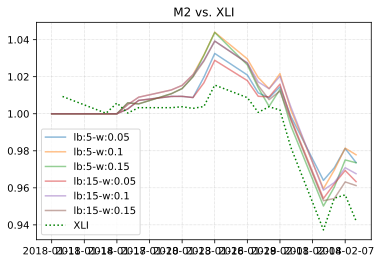

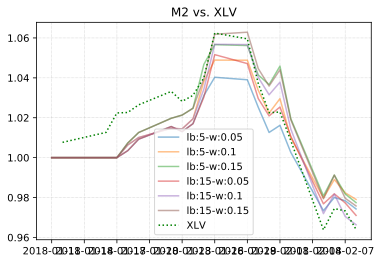

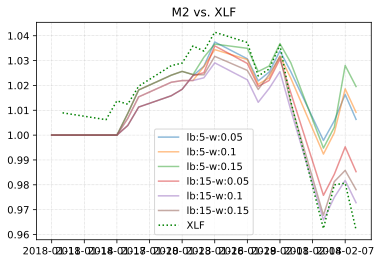

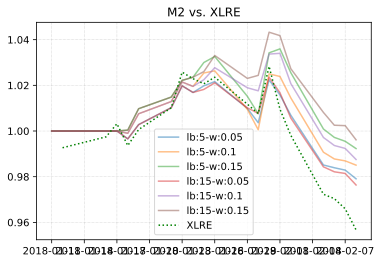

In [27]:
# All sectors
spys, arks = ticker_map['spy_sectors'], ticker_map['ark_etfs']
spyf, arkf = 'spy-sectors.csv', 'ark-etfs.csv'
log = False
for s in spys:
    dwld_key = s
    check_sector_vars(spyf, s, frame)
    #px_portion, returns, alloc, pdf, benchmark = run_sector_opt(spyf, dwld_key, hist_window, lb, we)
    #plot_two_series(pdf, benchmark, "M2", dwld_key, pdf.index.name, "Indexed Returns", "Optimization vs. ETF")
    #plt.show()

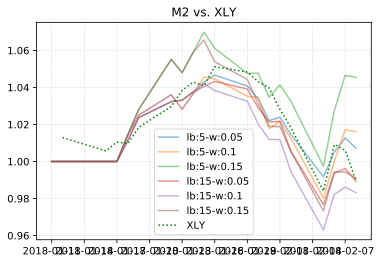

In [28]:
# Single lookback alpha
def plot_alpha_series(tsa, label1, xlabel, ylabel, title):
    plt.plot(tsa, alpha=0.3, label=label1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)

dwld_key = 'XLY'
log = False

check_sector_vars(spyf, dwld_key, frame)

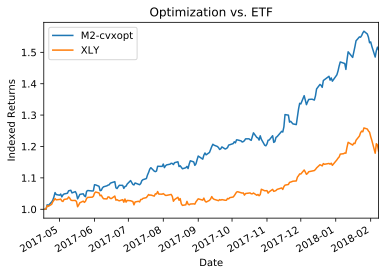

In [29]:
# Single sector long run
px_portion, returns, alloc, pdf, benchmark = run_sector_opt(spyf, dwld_key, hist_window, lb, we)
plot_two_series(pdf, benchmark, "M2", dwld_key, pdf.index.name, "Indexed Returns", "Optimization vs. ETF")
plt.show()

In [30]:
# Create Chart to show return spread vs. ETF for a given time window
# Conclusion: The shorter the holding gets the more likely to underperform
holding = 90; stop = int(len(alloc) - holding); jumps = 10
offsets = [x for x in range(0, stop, jumps)]
msg = "Portfolio metrics starting every {} trading days and holding for {} days"
print(msg.format(jumps, holding))
cols = ["M2", "Bechmark", "M2_Return", "M2_StdDev", "M2_Sharpe"]
results = pd.DataFrame([], index=offsets, columns=cols)
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')

dwld_key = 'XLY'
spyder_etf = px_spy_etfs[dwld_key].copy()

log = False
print('Working...')
for o in offsets:
    start = np.min([o, len(alloc)-1])
    end = np.min([o + holding, len(alloc)])
    p = px[start:end].copy()
    px_o, r, a, pdf = recommend_allocs(p, hist_window, lb, frequency, min_gross, max_gross, min_w, we)
    ret, std, sharpe = portfolio_metrics('M2', pdf);
    s_etf = spyder_etf[start:end]
    portfolio_metrics('ETF', pd.DataFrame(s_etf))
    results.loc[o, cols] = [compound(pdf)[-1:].values[0][0], compound(s_etf)[-1:].values[0], ret, std, sharpe]
print('Complete')

Portfolio metrics starting every 10 trading days and holding for 90 days
Working...
Complete


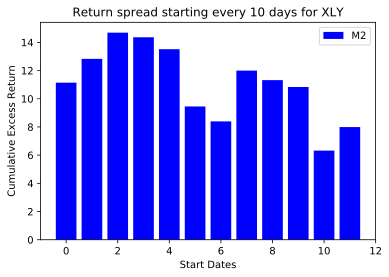

Portfolio underperformed: 0.0% of the time


In [31]:
def plot_spread_two_series(tsa, tsb, label1, label2, xlabel, ylabel, title):
    plt.bar(range(len(tsa)), (tsa - tsb)*100, label=label1, color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)

chart_title = "Return spread starting every {} days for {}".format(jumps, dwld_key)
rp = results[cols[0:2]].copy()
plot_spread_two_series(rp[cols[0]], rp[cols[1]], "M2", "Benchmark", "Start Dates", "Cumulative Excess Return", chart_title)
plt.show()

under = results[results["M2"] < results["Bechmark"]][results.columns[0]].count()
print("Portfolio underperformed: {0:.1f}% of the time".format(under/len(results)*100))

In [32]:
# show portfolio metrics for a given time window
log = True
msg = "Portfolio metrics for the last {} days"
print(msg.format(frame))
w = alloc[-frame:].astype(np.float)
r = returns[-frame:].astype(np.float)
port_perf = calc_port_performance(r.values, w.values)
pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
portfolio_metrics('M2', pdf);

Portfolio metrics for the last 60 days
M2 Return: 0.20, StdDev: 0.08, Sharpe: 2.42


2017 1.4023


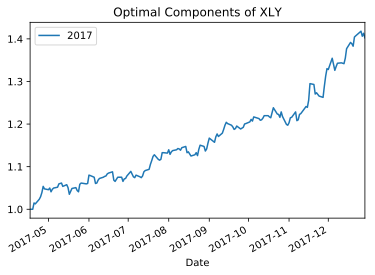

In [33]:
# plot portfolio performance by year
first_year = int(alloc.index[0].year)
last_year = int(alloc.index[-1].year)
years = [y for y in range(first_year, last_year, 1)] 

def perf_by_years(r, a, years):
    ax = plt.axes()
    for y in years:
        year = str(y)
        w = alloc.loc[year].astype(np.float16)
        r = returns.loc[year].astype(np.float16)
        p_perf = calc_port_performance(r.values, w.values)
        result = pd.DataFrame(p_perf, index=w.index, columns=[year])
        result.plot(title='Optimal Components of ' + dwld_key, ax=ax, legend='right')
        if log: print(year, result[-1:].values[0][0])

perf_by_years(returns, alloc, years)

In [34]:
# shows most frequent positions
top = 5
print("Number of Times for Top {} holdings during the last {} intervals".format(top, 99))
print((selected_allocs(alloc, frame, frequency, 99)[:top] / max_w).astype(np.int))
print("Number of Times for Top {} holdings during the last {} intervals".format(top, 5))
print((selected_allocs(alloc, frame, frequency, 5)[:top] / max_w).astype(np.int))
print("Number of Times for Top {} holdings during the last {} intervals".format(top, 1))
print((selected_allocs(alloc, frame, frequency, 1)[:top] / max_w).astype(np.int))

Number of Times for Top 5 holdings during the last 99 intervals
WYNN    3
FOXA    3
BBY     2
DG      2
HLT     2
dtype: int64
Number of Times for Top 5 holdings during the last 5 intervals
CCL     1
NCLH    1
HAS     1
AMZN    1
IPG     1
dtype: int64
Number of Times for Top 5 holdings during the last 1 intervals
IPG     0
TWX     0
OMC     0
FOXA    0
GPC     0
dtype: int64


#### Sensitivities

In [35]:
def create_matrix(group, dwld_key, lbs, mws, frame):
    print("Creating Sensitivity Matrix...")
    df = pd.DataFrame([], index=lbs, columns=mws)
    df.index.name = "Lookback"
    df.columns.name = "Max Exposure"
    for i, l in enumerate(lbs):
        for j, w in enumerate(mws):
            #r, w = get_weights(px, frequency, lb=l, max_w=w)
            #port_perf = calc_port_performance(r.values, w.values)
            #pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
            _, _, _, pdf, _ = run_sector_opt(group, dwld_key, frame, l, w)
            ret, std, sharpe = portfolio_metrics('M2', pdf);
            df.iloc[i, j] = (ret.astype(np.float16), std.astype(np.float16), sharpe.astype(np.float16))
    print("Complete")
    return df
def heatmap(df, ctitle, cmap=plt.cm.gray):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    ax.set_title(ctitle)
    plt.colorbar(axim)

In [36]:
lbs = [x for x in range(5, 30, 5)]
mws = [y/100 for y in [x for x in range(5, 30, 5)]]
log = False
sm = create_matrix(spyf, 'XLY', lbs, mws, frame)

Creating Sensitivity Matrix...
Complete


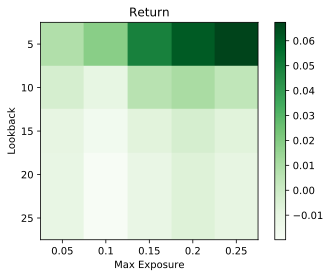

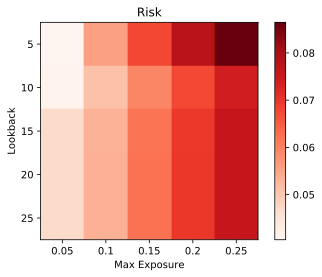

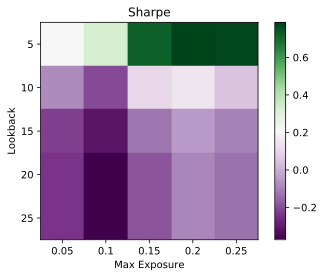

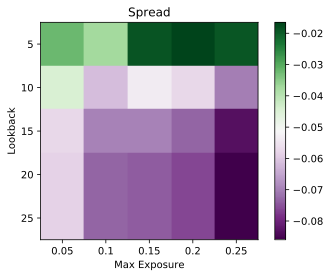

In [37]:
m_list = ["Return", "StdDev", "Sharpe"]
extract = lambda x: x[curr]
spread = lambda x: x[0] - x[1]
curr = 0; df = sm.applymap(extract); heatmap(df.astype(float), "Return", cmap=plt.cm.Greens)
curr = 1; df = sm.applymap(extract); heatmap(df.astype(float), "Risk", cmap=plt.cm.Reds)
curr = 2; df = sm.applymap(extract); heatmap(df.astype(float), "Sharpe", cmap=plt.cm.PRGn)
df = sm.applymap(spread); heatmap(df.astype(float), "Spread", cmap=plt.cm.PRGn)

In [ ]:
sm

#### Old Cells

In [402]:
# Rank companies
ranked_cos = summary[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
top_picks = summary.loc[ranked_cos[:top].index]
print("\nPortfolio Sector Exposures")
print(top_picks.groupby(by='Sector')['Alloc'].count() / len(top_picks))
print("Top 20 companies ranked from best to worst\n")
top_picks


Portfolio Sector Exposures
Sector
XLF    0.285714
XLI    0.071429
XLK    0.142857
XLP    0.071429
XLV    0.142857
XLY    0.285714
Name: Alloc, dtype: float64
Top 20 companies ranked from best to worst



Alloc       Ret       Std    Sharpe    Spread Sector
NFLX  0.027837  0.231478  0.147565  1.568647  0.083913    XLY
AMZN  0.070000  0.131026  0.084113  1.557750  0.046914    XLY
XL    0.070000  0.114449  0.067208  1.702901  0.047241    XLF
DPS   0.070000  0.256373  0.232208  1.104068  0.024165    XLP
RE    0.070000  0.111661  0.086638  1.288819  0.025023    XLF
HAS   0.070000  0.115190  0.098808  1.165796  0.016382    XLY
HCA   0.070000  0.109797  0.092595  1.185772  0.017202    XLV
EW    0.070000  0.081686  0.071065  1.149464  0.010622    XLV
AON   0.070000  0.062261  0.049642  1.254207  0.012619    XLF
MSI   0.070000  0.067208  0.066834  1.005598  0.000374    XLK
NOC   0.070000  0.076088  0.079095  0.961989 -0.003006    XLI
EA    0.070000  0.085106  0.093728  0.908011 -0.008622    XLK
TRIP  0.070000  0.157214  0.174042  0.903307 -0.016829    XLY
CME   0.070000  0.061250  0.064216  0.953810 -0.002966    XLF

Loaded pricing for XLRE-hold-pricing.csv, with shape (870, 33)
Loaded pricing for spy-sectors.csv, with shape (870, 10)
M2 Return: 40.46%, StdDev: 14.11%, Sharpe: 2.87
XLRE Return: 22.15%, StdDev: 26.95%, Sharpe: 0.82


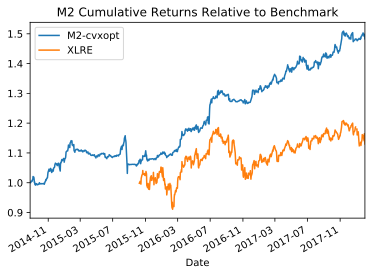

In [16]:
#Produce optimization for a given sector group
dwld_key = 'XLRE'
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
spyder_etf = px_spy_etfs[dwld_key].copy()

# Run a sector specific optimization
px_portion, returns, alloc, pdf = recommend_allocs(px, hist_window, lookback, frequency, max_w=0.1)
portfolio_metrics('M2', pdf);
s_etf = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
portfolio_metrics(dwld_key, pd.DataFrame(s_etf));

# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_etf.plot(ax=ax, legend='right');

In [ ]:
for x in ['arkq', 'arkw', 'arkg', 'arkk']:
    df = clean_load(r'holdings-ark-', 'ticker', ['ticker','company', 'weight(%)'], col_names, x, 0)
    df = clean_idx(df, ' ')
    print(df.tail())

In [ ]:
df = clean_load(r'holdings-ark-', 'ticker', ['ticker','company', 'weight(%)'], col_names, 'arkk', 0)
df = clean_idx(df, ' ')
df

In [217]:
np.random.seed(42)
vals = np.random.random(25).reshape(5,5)
idx = [x for x in range(1, 6, 1)]
df = pd.DataFrame(vals, index=idx, columns=idx)
df = df * 10; df.loc[1:3, 3] = 0.1
df.applymap(cleanmin)

1         2         3         4         5
1  3.745401  9.507143  1.000000  5.986585  1.560186
2  1.559945  1.000000  1.000000  6.011150  7.080726
3  1.000000  9.699099  1.000000  2.123391  1.818250
4  1.834045  3.042422  5.247564  4.319450  2.912291
5  6.118529  1.394939  2.921446  3.663618  4.560700

In [ ]:
# Old load spy sector components

sectors = ticker_map['spy_sectors']
sector_tickers_map = {}
companies = pd.DataFrame([])

colstoload = ['Symbol','Company Name', 'Index Weight']
pattern = r'holdings-spy-'

#def load_components(pattern, cols, skiprows=1, sectors, ):
    
flist = os.listdir(component_path)
files = [f for f in flist if f.startswith(pattern)]
for s in sectors:
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=1, index_col='Symbol', usecols=colstoload)
    df['ETF'] = s
    sector_tickers_map[s] = df.index.tolist()
    companies = companies.append(df)
if log: print("Company Sample:", companies.shape); 

px_etfs = load_pricing('sectors-spy.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

# load ark etfs components

In [ ]:
df = pd.DataFrame(np.random.random(15).reshape(5,3), index=[1,2,np.nan," ", "asd asd"], columns=['A','B','C'])
df.index.name = 'Symbol'
df.loc[' '] = " "; df.loc['asd asd'] = " "
df.loc[2,'B'] = np.nan
df
clean_idx(df, ' ')

In [ ]:
retail = load_pricing('XLY' + '-hold-pricing.csv', 'Date')
retail = clean_nas(retail)
l = 300
amzn = retail['AMZN'].tail(l)
portfolio_metrics('AMZN', pd.DataFrame(amzn));
amzn.pct_change().mean() * l, amzn.pct_change().std() * sqrt(l)
amzn[-1:].values / amzn[:1].values

In [303]:
px = load_pricing('ARKK' + '-hold-pricing.csv', 'Date')
px = clean_nas(px)
px.describe().T.sort_values('min').head(15)

Loaded pricing for ARKK-hold-pricing.csv, with shape (870, 55)


count         mean          std   min      25%       50%          75%  \
MGTI  870.0     1.532535     0.960380  1.00   1.0000     1.000     1.717500   
BCG   870.0  6663.560407  5891.692855  1.00   1.0000  5985.000  7235.555054   
GBTC  870.0     3.064629     5.048063  1.00   1.0000     1.000     1.383324   
ONVO  870.0     3.525310     1.562290  1.34   2.4800     3.080     4.175000   
CERS  870.0     4.688195     1.204305  2.02   4.0300     4.690     5.607500   
CGEN  870.0     5.795115     1.733529  2.35   4.4000     6.150     6.970000   
PACB  870.0     6.336701     2.323733  2.52   4.7025     5.830     8.127500   
HDP   870.0    14.847213     6.830295  3.25   9.6925    12.925    20.799999   
LC    870.0    10.686368     6.771614  3.51   5.4425     6.450    14.825000   
VCYT  870.0     7.653247     1.670535  4.51   6.4800     7.710     8.487500   
MTLS  870.0     9.348149     2.628014  5.38   7.3700     8.350    11.017500   
NVTA  870.0    10.764092     3.570513  5.95   8.3500     9.380    12.047500   
XONE  870.0    12.189230     4.152230  6.19   9.8925    10.785    13.557500   
NSTG  870.0    14.760287     3.488499  6.95  12.6600    14.815    16.490000   
BB    870.0     7.775586     1.268051  7.10   7.3700     7.490     7.490000   

               max  
MGTI      7.100000  
BCG   21851.900391  
GBTC     38.054947  
ONVO      7.960000  
CERS      7.390000  
CGEN      9.710000  
PACB     13.450000  
HDP      29.200001  
LC       27.900000  
VCYT     12.870000  
MTLS     16.290001  
NVTA     21.629999  
XONE     29.879999  
NSTG     23.270000  
BB       14.400000

In [ ]:
px = load_pricing('test-XLRE' + '-hold-pricing.csv', 'Date')
clean = clean_nas(px)
cols = clean.columns[:10]
clean[cols]

In [ ]:
vals = np.arange(9).reshape(3, 3)
vals
m2 = np.array([vals[0], vals[1], vals[2]])
m2
matrix = pd.DataFrame(m2, index=['1','2','3'], columns=['A','B','C'])
#matrix[matrix.columns] = vals
matrix
[dwld_key] * 10

In [ ]:
# Downloads pricing from yahoo for components + sector ETF
tickers = sector_tickers_map[dwld_key] # for individual components
#tickers = ticker_map["sectors"] # for individual ETFs
px = get_pricing(dwld_key + '-hold-pricing.csv', tickers, start_date.strftime(date_fmt))
etf = get_pricing(dwld_key + '.csv', dwld_key, start_date.strftime(date_fmt))
spyder_etf = pd.DataFrame(etf)
spyder_etf.index.name = "Date"
spyder_etf.columns=[dwld_key]
spyder_etf.to_csv(dwld_key + '.csv')

In [ ]:
#CHECK compounding math
#what were the top 10 allocations tickers?
top_stocks = alloc.sum(axis=0).sort_values(ascending=False)[:10].index.tolist()
# what was their allocation?
alloc = alloc[top_stocks]
# how much did we allocate to them?
cum_alloc = alloc.sum(axis=1)
# multiply the daily returns of top allocations times our allocation
port_return = (returns[top_stocks] * alloc).sum(axis=1)
# we add 1 to get the compounding index
port_index = (port_return + 1).cumprod()
#cumulative return for the portfolio
print(port_index[-1:], len(port_index), "days")

port_perf = calc_port_performance(returns[top_stocks].values, alloc.values)
print(port_perf[-1:], len(port_perf), "days")
print("annual return", pd.Series(port_perf).pct_change().mean() * 252)

In [ ]:
# show behaviour during sepcific time window
start = '1-1-2017'; days = 15
end = datetime.strptime(start, date_fmt) + timedelta(days)
window = pdf.loc['2017-1-31':'2017-9-30']
portfolio_metrics(window)

In [ ]:
for s in sector_tickers_map.keys():
    print(len(sector_tickers_map[s]))
    
#test both the portfolio performance using date intervals with optimization
df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_allocations = pd.DataFrame(np.zeros((len(intervals),cols)), index=pd.to_datetime(intervals))

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(mean_returns, cov_matrix)
    hist_allocations.loc[i.date()] = weights

port_perf = calc_port_performance(df.loc[intervals].values, hist_allocations.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

#### Test Methods

In [ ]:
d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))

df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
(df+1).cumprod().mean(axis=1).plot()

In [ ]:
#test both the portfolio performance using date intervals without optimization / equal weights
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    #lb_returns = df.loc[:i.date()].tail(lookback)
    weights = np.array([1/cols for _ in range(cols)])
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')

port_perf = calc_port_performance(df.values, hist_alloc.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
#test both the portfolio performance using date intervals with optimization
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(n, mean_returns, cov_matrix, min_w=0.0, max_w=0.3)
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
hist_alloc

port_perf = calc_port_performance(df.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf)
pdf.plot()
port_perf[-1:]

In [ ]:
px = get_pricing(ticker_map[key], '01/01/2017')
returns = px.sort_index().pct_change()
compound(returns).plot()

In [ ]:
w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(returns)

ann_returns = np.dot((mean_returns * 252), weights)
ann_stdev = np.sqrt(252/len(returns)) * std_dev
print(weights.shape, cov_matrix.shape)
port_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
print("eq weight return(exp)", ann_returns)
print("port risk(exp):", port_variance)
print("sharpe ratio:", ann_returns / port_variance)

In [ ]:
# Long only portfolio optimization.
weights = get_mvo_allocations(mean_returns, cov_matrix)
np_weights = np.array([weights]).T
exp_return = np.dot(np.array([mean_daily_returns.values]), np_weights) * 252
portfolio_std_dev = np.sqrt(np.dot(np_weights.T, np.dot(cov_matrix, np_weights))) * np.sqrt(252)
print("optimized return(exp):", exp_return)
print("optimized portfolio risk(exp):", portfolio_std_dev)
print("sharpe ratio:", exp_return / portfolio_std_dev)

In [ ]:
# Compute trade-off curve.
SAMPLES = 100
weights = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    weights.append([i[0] for i in w.value.tolist()])
    risk_data[i] = cvx.sqrt(risk).value
    ret_data[i] = ret.value
print('Optimization status:', prob.status)
#w.value, risk_data, ret_data
#ret_data / risk_data # sharpe ratio
#risk_data[np.argmin(risk_data)], risk_data[np.argmax(ret_data)]
#wgt_cum_ret = (ret_data + 1).cumprod()
cols = returns.columns.tolist();
allocs = show_weights(weights, returns.columns, ret_data, risk_data); allocs.tail()
allocs[cols].plot()
print(allocs[-1:].apply(two_dec))

In [ ]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = range(1, 100, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker], ret_data[marker]))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    ax.annotate(returns.columns[i], xy=(sqrt(Sigma[i,i]).value, mu[i]))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
gamma_vals.shape, risk_data.shape, ret_data.shape
summary = pd.DataFrame([], columns=['gamma', 'risk', 'return'], index=range(SAMPLES))
summary['gamma'] = np.array([gamma_vals]).T
summary['risk'] = np.array([risk_data]).T
summary['return'] = np.array([ret_data]).T
summary[['risk','return']].plot(kind='line')

In [ ]:
numdays, cols = 252, 10

np.random.seed(42)
numdays, cols = 100, 10
end_date_str, tgt_date_str = '12-31-2017', '12-27-2017'
freq = 7; lookback = 20

arr = (np.random.rand(numdays, cols) - 0.5) / 10
weights = np.random.rand(1, cols)
weights = weights / np.sum(weights, axis=1).T

In [ ]:
#test the portfolio performance calculation
port_perf = calc_port_performance(arr, weights)
#pd.DataFrame(port_perf).plot()
port_perf

In [ ]:
#test the date rules / intervals
end_date = datetime.strptime(end_date_str, date_fmt)
d_rng = sorted([end_date - timedelta(x) for x in range(0, numdays)]) # using list comprenhensions
sorted(date_rules(d_rng, tgt_date_str, freq))

d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))
intervals = list(sorted(date_rules(d_rng, tgt_date_str, freq)))
print("check:", len(intervals), "equals", numdays // freq, "result:",len(intervals) == numdays // freq) # check if intervals works
intervals[-5:]